In [18]:
import argparse
import logging
import os
import random
import numpy as np
import torch
import torch.backends.cudnn as cudnn
from datasets.dataset_synapse import Synapse_dataset, RandomGenerator
from importlib import import_module
from sam_lora_image_encoder import LoRA_Sam
from segment_anything import sam_model_registry
from trainer import trainer_synapse
from icecream import ic
import sys
import time
import math
import torch.nn as nn
import torch.optim as optim
from tensorboardX import SummaryWriter
from torch.nn.modules.loss import CrossEntropyLoss
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
from utils import DiceLoss, Focal_loss
from torchvision import transforms
from trainer import calc_loss

base_lr = 0.005
num_classes = 8
batch_size = 2
base_dir = 'train_npz_new_224'
list_dir = 'lists/lists_Synapse'
ckpt = 'checkpoints/sam_vit_b_01ec64.pth'
img_size = 224
vit_name = 'vit_b'
seed = 1234
module = 'sam_lora_image_encoder'
rank = 2
max_epochs = 200
stop_epoch = 160
warmup = False
warmup_period = 250
AdamW = True
dice_param = 0.8

add_by_me = True

In [20]:
sam, img_embedding_size = sam_model_registry[vit_name](image_size=img_size,
                                                                num_classes=num_classes,
                                                                checkpoint=ckpt, pixel_mean=[0, 0, 0],
                                                                pixel_std=[1, 1, 1])

low_res = low_res = img_embedding_size * 4
if num_classes > 1:
    multimask_output = True
else:
    multimask_output = False

# max_iterations = args.max_iterations
db_train = Synapse_dataset(base_dir= base_dir, list_dir=list_dir, split="train",
                           transform=transforms.Compose(
                               [RandomGenerator(output_size=[img_size, img_size], low_res=[low_res, low_res])]))
print("The length of train set is: {}".format(len(db_train)))
def worker_init_fn(worker_id):
    random.seed(seed + worker_id)

### add by me
if add_by_me:
    num_train = int(0.01 * len(db_train))
    num_val = len(db_train) - num_train
    db_train, db_val = torch.utils.data.random_split(db_train, [num_train, num_val])
    print("The length of train set now is: {}".format(len(db_train)))

trainloader = DataLoader(db_train, batch_size=batch_size, shuffle=True, #num_workers=8, pin_memory=True,
                         worker_init_fn=worker_init_fn)
pkg = import_module(module)
model = pkg.LoRA_Sam(sam, rank).cuda()

The length of train set is: 2211
The length of train set now is: 22


In [21]:
model.train()
ce_loss = CrossEntropyLoss()
dice_loss = DiceLoss(num_classes + 1)
if warmup:
    b_lr = base_lr / warmup_period
else:
    b_lr = base_lr
if AdamW:
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=b_lr, betas=(0.9, 0.999), weight_decay=0.1)
else:
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=b_lr, momentum=0.9, weight_decay=0.0001)

#iter_num = 0
max_epoch = max_epochs
#stop_epoch = stop_epoch
#max_iterations = max_epochs * len(trainloader)  # max_epoch = max_iterations // len(trainloader) + 1
#logging.info("{} iterations per epoch. {} max iterations ".format(len(trainloader), max_iterations))
#best_performance = 0.0
#iterator = tqdm(range(max_epoch), ncols=70)
print('training start!')
for epoch_num in range(max_epoch):
    for i_batch, sampled_batch in enumerate(trainloader):
        image_batch, label_batch = sampled_batch['image'], sampled_batch['label']  # [b, c, h, w], [b, h, w]
        low_res_label_batch = sampled_batch['low_res_label']
        image_batch, label_batch = image_batch.cuda(), label_batch.cuda()
        low_res_label_batch = low_res_label_batch.cuda()
        assert image_batch.max() <= 3, f'image_batch max: {image_batch.max()}'
        outputs = model(image_batch, multimask_output, img_size)
        #print(outputs)

        loss, loss_ce, loss_dice = calc_loss(outputs, low_res_label_batch, ce_loss, dice_loss, dice_param)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(loss)
    print(f'epoch: {epoch_num}; loss: {loss}; loss_ce: {loss_ce}; loss_dice: {loss_dice} ')
    if epoch_num>=5:
        break

training start!
epoch: 0; loss: 0.6788018941879272; loss_ce: 1.5976669788360596; loss_dice: 0.44908565282821655 
epoch: 1; loss: 0.31353986263275146; loss_ce: 0.23127608001232147; loss_dice: 0.33410581946372986 
epoch: 2; loss: 0.9651060104370117; loss_ce: 1.6533548831939697; loss_dice: 0.7930437326431274 
epoch: 3; loss: 0.724643349647522; loss_ce: 0.8267245888710022; loss_dice: 0.6991230249404907 
epoch: 4; loss: 0.6046521067619324; loss_ce: 0.795106053352356; loss_dice: 0.5570386052131653 
epoch: 5; loss: 0.6956703066825867; loss_ce: 1.6818792819976807; loss_dice: 0.449118047952652 


In [39]:
print(outputs.keys())
print('batch size:', batch_size)
print('mask shape:', outputs['masks'].shape)
print('image input shape', image_batch.shape)
print('label inout shape', label_batch.shape)
print('iou_predictions shape', outputs['iou_predictions'].shape)
print('low_res_logits shape', outputs['low_res_logits'].shape)

dict_keys(['masks', 'iou_predictions', 'low_res_logits'])
batch size: 2
mask shape: torch.Size([2, 9, 224, 224])
image input shape torch.Size([2, 3, 224, 224])
label inout shape torch.Size([2, 224, 224])
iou_predictions shape torch.Size([2, 9])
low_res_logits shape torch.Size([2, 9, 56, 56])


In [35]:
sample = db_train[10]
print('the keys in the sample:', sample.keys())
print('for training image,')
print(sample['image'].shape)
print(sample['image'].dtype)
print(sample['image'].max())
print(sample['image'].min())
# Question: why the image is not normalized from 0 to one, but something else?

print('for training label')
print(sample['label'].shape)
print(sample['label'].dtype)
print(sample['label'].max())

print('for training label')
print(sample['low_res_label'].shape)
print(sample['low_res_label'].dtype)
print(sample['low_res_label'].max())

the keys in the sample: dict_keys(['image', 'label', 'low_res_label', 'case_name'])
for training image,
torch.Size([3, 224, 224])
torch.float32
tensor(1.1247)
tensor(-0.1058)
for training label
torch.Size([224, 224])
torch.int64
tensor(7)
for training label
torch.Size([56, 56])
torch.int64
tensor(7)


#### data visulization

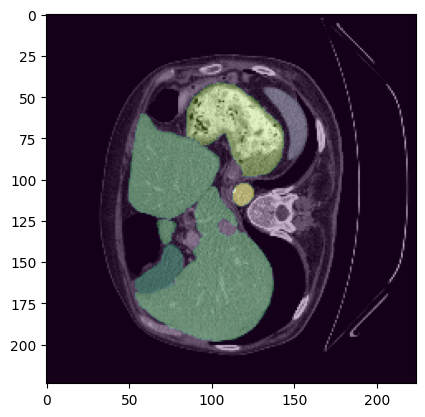

In [49]:
sample = db_train[10]
image = sample['image']
label = sample['label']

import matplotlib.pyplot as plt
plt.imshow(image.permute(1,2,0).numpy())
plt.imshow(label, alpha=0.3)